In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [3]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
data_dir='./data/cifar10/'
classes=os.listdir(data_dir+'/train')
print(classes)

['cat', 'truck', 'ship', 'horse', 'deer', 'automobile', 'frog', 'bird', 'dog', 'airplane']


In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [6]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [7]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [8]:
from torch.utils.data import DataLoader

In [9]:
batch_size = 256

In [10]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, 
                      num_workers=2, pin_memory=True)

In [11]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
        break

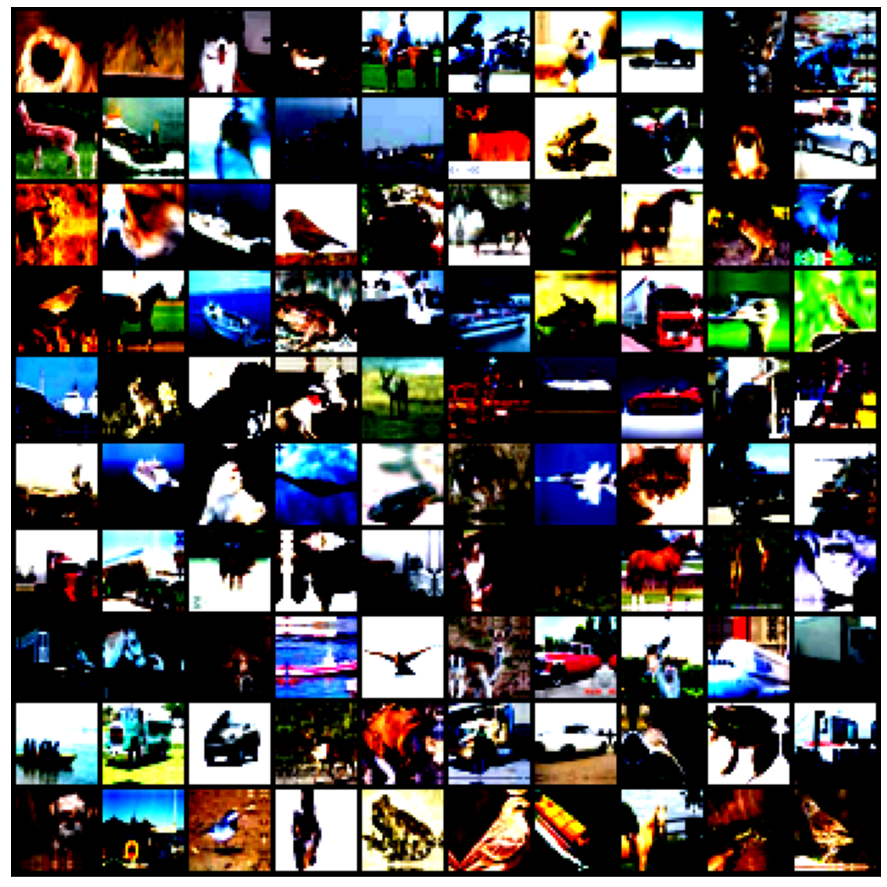

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(ImageClassificationBase):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def wrn_22(): 
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
model = wrn_22()

In [23]:
model.cuda()

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [24]:
# to_device(wrn_22(),device)

In [25]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 10])


In [26]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.303171157836914, 'val_acc': 0.09765625}]

In [27]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [28]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00104, train_loss: 1.4012, val_loss: 1.1931, val_acc: 0.5698
Epoch [1], last_lr: 0.00279, train_loss: 0.9842, val_loss: 1.0786, val_acc: 0.6366
Epoch [2], last_lr: 0.00519, train_loss: 0.8213, val_loss: 1.1103, val_acc: 0.6433
Epoch [3], last_lr: 0.00760, train_loss: 0.7338, val_loss: 1.0337, val_acc: 0.6347
Epoch [4], last_lr: 0.00936, train_loss: 0.6921, val_loss: 0.8349, val_acc: 0.7179
Epoch [5], last_lr: 0.01000, train_loss: 0.6508, val_loss: 0.8031, val_acc: 0.7388
Epoch [6], last_lr: 0.00987, train_loss: 0.6116, val_loss: 0.8010, val_acc: 0.7307
Epoch [7], last_lr: 0.00950, train_loss: 0.5866, val_loss: 1.0006, val_acc: 0.6820
Epoch [8], last_lr: 0.00891, train_loss: 0.5549, val_loss: 0.6616, val_acc: 0.7830
Epoch [9], last_lr: 0.00812, train_loss: 0.5228, val_loss: 0.8784, val_acc: 0.7341
Epoch [10], last_lr: 0.00717, train_loss: 0.4871, val_loss: 0.6947, val_acc: 0.7787
Epoch [11], last_lr: 0.00611, train_loss: 0.4550, val_loss: 0.5455, val_acc: 0.8146
Ep

In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

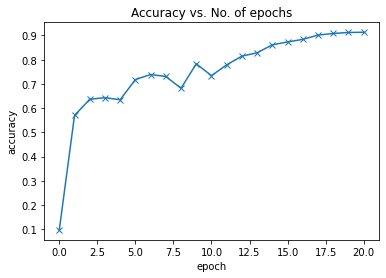

In [30]:
plot_accuracies(history)

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

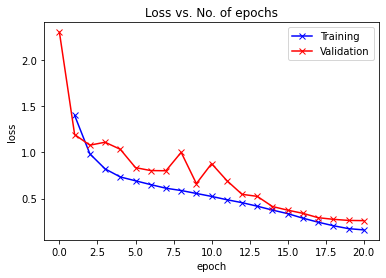

In [32]:
plot_losses(history)

In [33]:
def plot_lrs(history):
    import numpy as np
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

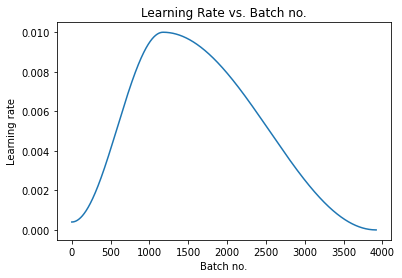

In [34]:
plot_lrs(history)